# Dependency

In [247]:
import math
import pandas as pd
import numpy as np
from pandas_datareader import data as wb # datareader supports multiple financial database including yahoo and google
import datetime
from dateutil.relativedelta import relativedelta
import GetOldTweets3 as tws
import tweepy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor # Import library for VIF

%matplotlib inline

# Data Fetching
## Start & End Date

In [170]:
date_rang_month = 3
start_date = datetime.date.today() + relativedelta(months=-date_rang_month)
end_date = datetime.date.today()

## Stock Data

In [ ]:
tickers = \
[
    ("TSLA", "yahoo"), # 0, TESLA Stock
    ("DJIA", "fred"), # 1, Dow Jones Index Average
    ("DFF", "fred"), # 2, Federal Funds Rate
    ("PCRFY", "yahoo"), # 3, Panasonic Corp. Stock
    ("BMW.DE", "yahoo"), # 4, BMW Stock
    ("DAI.DE", "yahoo"), # 5, Daimler AG Stock
    ("XPEV", "yahoo"), # 6, XPeng Inc. Stock
    ("BYDDF", "yahoo"), # 7, BYD Company Limited Stock
    ("BZ=F", "yahoo") # 8, Brent Crude Oil Last Day Finance
]

stock_dfs = list()
for ticker, source in tickers:
    if source == "fred":
        df = pd.DataFrame(wb.DataReader(ticker, 
                                        data_source = source, 
                                        start = start_date + relativedelta(days = -1), 
                                        end = end_date))
    else:
        df = pd.DataFrame(wb.DataReader(ticker, 
                                        data_source = source, 
                                        start = start_date, 
                                        end = end_date))
    stock_dfs.append(df)

oil_df = stock_dfs[len(stock_dfs) - 1] # give another name to the df for Brent Crude Oil Last Day Finance

## Number of Tesla vehicles delivered worldwide 

In [168]:
quaters = [
    (r'q2', r'2019'),
    (r'q3', r'2019'),
    (r'q4', r'2019'),
    (r'q1', r'2020'),
    (r'q2', r'2020'),
    (r'q3', r'2020')
]

deliver_df = list()
for q, year in quaters:
    url = r'https://ir.tesla.com/press-release/tesla-' + q + r'-' + year + r'-vehicle-production-deliveries'
    tables = pd.read_html(url)
    tmp = list()
    for row in range(1,4):
        for col in range(1, 3):
            if q == r'q2' and year == r'2019':
                tmp.append(tables[0].iloc[row, col + 1])
            else:
                tmp.append(tables[0].iloc[row, col])
    deliver_df.append(tmp)
deliver_df = pd.DataFrame(deliver_df,
                          columns= [
                              "Production Model S/X",
                              "Deliveries Model S/X",
                              "Production Model 3",
                              "Deliveries Model 3",
                              "Production Total",
                              "Deliveries Total",
                         ])
# deliver_df

## Tesla Revenue

In [171]:
revenue_df = pd.read_html(r'https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue')
revenue_df = revenue_df[1]

# Data Cleaning

Currently, the data used includes:

1. Tesla Stock `tsla_df`
2. Dow Jones Index Average `djia_df`
3. Federal Funds Rate `dff_df`
4. Panasonic Corp. Stock `pcrfy_df`
5. BMW Stock `bwm_df`
6. Daimler AG Stock `dai_df`
7. XPeng Inc. Stock `xpev_df`
8. BYD Company Limited Stock `byddf_df`
9. Brent Crude Oil Last Day Financ `oil_df`
10. Number of Tesla vehicles delivered worldwide `deliver_df`
11. Tesla Revenue `revenue_df`

Actually, in the last section, we have done a bit of data Cleaning, like

1. drop nan/missing values 
2. reset the index of dataframe to include `date` as one column in the dataframe

However, we still need to do more:

1. Renaming columns to a more recognizable set of labels 
2. Dropping unnecessary columns in a DataFrame
3. do some more modification on `deliver_df` and `revenue_df`
4. Combine all these dataframe to a complete DataFrame

## Clean `revenue_df`

In [ ]:
# rename the dataframe
revenue_df.columns = ["Date", "Tesla Quarterly Revenue(Millions of US $)"]

# drop rows with missing values
revenue_df = revenue_df.dropna()

# transfer data type of "Date" from string to TimeStamp
revenue_df["Date"] = revenue_df["Date"].map(pd.Timestamp)

# transfer data type of "Tesla Quarterly Revenue(Millions of US $)" from string to decimal
def doller2decimal(target):
    return float(target.replace(",", "").replace("$", ""))
revenue_df["Tesla Quarterly Revenue(Millions of US $)"] = revenue_df["Tesla Quarterly Revenue(Millions of US $)"].apply(doller2decimal)

# reorder the revenue_df to ascending order by Date
revenue_df = revenue_df.sort_values(by = ["Date"], ascending = True)

revenue_df.tail(5)


## Clean `deliver_df`

In [156]:
# convert each line to float number
for col in deliver_df.columns.to_list():
    deliver_df[col] = deliver_df[col].apply(float)
# add "Date" to the dataframe deliver_df
deliver_df["Date"] = revenue_df["Date"][-len(deliver_df):].reset_index()["Date"]
deliver_df = deliver_df[deliver_df.columns.to_list()[-1:] + deliver_df.columns.to_list()[:-1]] # reorder the columns

deliver_df

,Date,Production Model S/X,Deliveries Model S/X,Production Model 3,Deliveries Model 3,Production Total,Deliveries Total
0,2019-06-30,14517.0,17650.0,72531.0,77550.0,87048.0,95200.0
1,2019-09-30,16318.0,17400.0,79837.0,79600.0,96155.0,97000.0
2,2019-12-31,17933.0,19450.0,86958.0,92550.0,104891.0,112000.0
3,2020-03-31,15390.0,12200.0,87282.0,76200.0,102672.0,88400.0
4,2020-06-30,6326.0,10600.0,75946.0,80050.0,82272.0,90650.0
5,2020-09-30,16992.0,15200.0,128044.0,124100.0,145036.0,139300.0


## Clean `stock_dfs`
### DataFrames Plotting 

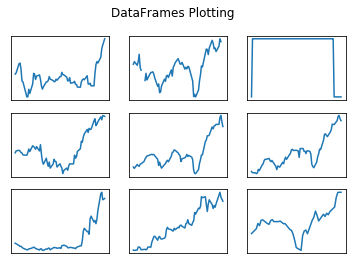

In [176]:
fig, axs = plt.subplots(3, 3)
fig.suptitle("DataFrames Plotting")
for i in range(len(stock_dfs)):
    axs[int((i - i % 3) / 3), i % 3].plot(stock_dfs[i].index, stock_dfs[i].iloc[:, 0])
for i in range(3):
    for ax in axs[:, i]:
        ax.label_outer()
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

From above plot, it is clear that there are some missing values in our data, however, due to the size of data is small, we can not simply remove one row or one column from our data which contains few missing values. Therefore, I would like to use polynomial filling to do the data interpolation. 

### Interpolation

In [191]:
for i in range(len(stock_dfs)):
    stock_dfs[i] = stock_dfs[i].interpolate(method='linear', order=2, limit_direction='forward', axis=0)
    # check if there is still some missing value in our dataframe.
    if np.sum(np.sum(stock_dfs[i].isnull(), axis=1), axis = 0) > 0:
        print(tickers[i][0] + " still have missing values after interpolation")
        stock_dfs[i] = stock_dfs[i].dropna()

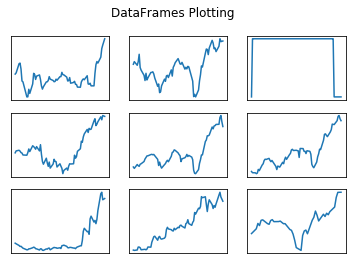

In [192]:
fig, axs = plt.subplots(3, 3)
fig.suptitle("DataFrames Plotting")
for i in range(len(stock_dfs)):
    axs[int((i - i % 3) / 3), i % 3].plot(stock_dfs[i].index, stock_dfs[i].iloc[:, 0])
for i in range(3):
    for ax in axs[:, i]:
        ax.label_outer()
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

## Combine `stocks_dfs`

In [193]:
# rename the df in stock_dfs to a more reasonable name
for df, ticker in zip(stock_dfs, tickers):
    if ticker[1] != "fred":
        new_col_names = [ticker[0] + " " + col for col in df.columns.to_list()]
        df.columns = new_col_names

In [194]:
# combine all the dataframes except for Brent Crude Oil Last Day Finance
stock_df = pd.concat(stock_dfs[:-1], axis=1)
# clean the missing values
stock_df = stock_df.dropna()

stock_df.tail(5)

,TSLA High,TSLA Low,TSLA Open,TSLA Close,TSLA Volume,TSLA Adj Close,DJIA,DFF,PCRFY High,PCRFY Low,...,XPEV Open,XPEV Close,XPEV Volume,XPEV Adj Close,BYDDF High,BYDDF Low,BYDDF Open,BYDDF Close,BYDDF Volume,BYDDF Adj Close
2020-11-19,508.609985,487.570007,492.000000,499.269989,62475300.0,499.269989,29483.23,0.08,10.55,10.40,...,41.720001,48.110001,35122700.0,48.110001,22.830000,22.280001,22.549999,22.670000,570800.0,22.670000
2020-11-20,502.500000,489.059998,497.989990,489.609985,32807300.0,489.609985,29263.48,0.08,10.66,10.42,...,48.660000,53.889999,79374800.0,53.889999,23.790001,23.410000,23.790001,23.770000,558100.0,23.770000
2020-11-23,526.000000,501.790009,503.500000,521.849976,50260300.0,521.849976,29591.27,0.08,10.89,10.62,...,56.750000,72.169998,100012200.0,72.169998,26.379999,24.600000,26.000000,26.379999,965000.0,26.379999
2020-11-24,559.989990,526.200012,540.400024,555.380005,53648500.0,555.380005,30046.24,0.08,10.75,10.55,...,72.169998,70.629997,99907800.0,70.629997,27.200001,25.700001,27.200001,26.110001,819900.0,26.110001
2020-11-25,574.000000,545.369995,550.059998,574.000000,48930200.0,574.000000,29872.47,0.08,10.95,10.73,...,64.650002,64.269997,49197400.0,64.269997,25.820000,24.809999,25.129999,25.170000,524700.0,25.170000


# PCA
## Multicollinearity

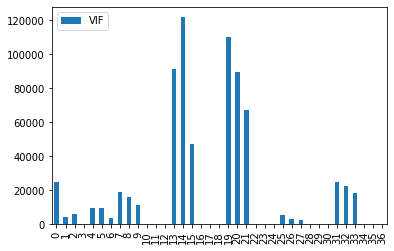

In [252]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

vif = calc_vif(stock_df.iloc[:, list(range(3)) + list(range(4, len(stock_df.columns)))])
vif.plot(kind="bar")

From above plots, it is shows that the multicollinearity is really high. Therefore, we choose to use PCA to firstly transform our data.

<u>note:</u> the columns with empty values shows infinity mulicollinearity. 

## PCA

In [286]:
# firstly extract predictors from data.
stock_df_x = stock_df.iloc[:, list(range(3)) + list(range(4, len(stock_df.columns)))].values
stock_df_x = StandardScaler().fit_transform(stock_df_x)

# Use PCA to remove some mulicollinearity in data.
pca = PCA(n_components = 0.99) # explain about 95% variance in data
stock_df_pca = pca.fit_transform(stock_df_x)
stock_pca_df = pd.DataFrame(data = stock_df_pca, 
                    columns = ["pc " + str(i) for i in range(stock_df_pca.shape[1])],
                    index = stock_df.index)

In [287]:
stock_y_mean = stock_df.iloc[:, 3].mean() # mean of lable
stock_y_stderr = stock_df.iloc[:, 3].sem() # variance of label
stock_pca_df = pd.concat([stock_pca_df, (stock_df.iloc[:, 3] - stock_y_mean) / stock_y_stderr], axis = 1) # combine X and Y

# Data Splitting

Use data in the last month as test data and others as train data

In [294]:
train_df = stock_pca_df.iloc[0:round(len(stock_pca_df) * 2 / 3), :]
test_df = stock_pca_df.iloc[round(len(stock_pca_df) * 2 / 3):len(stock_pca_df), :]